In [1]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as  mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
from Bio import PDB
import mdtraj as md
import numba as nb

parent_path = Path("/data/jgut/msa-tests")
df = pd.read_csv(parent_path/"porter_data.csv", header=None)
pd.set_option('display.max_columns', None)

def get_plddts(file_name):
    parser = PDB.PDBParser(PERMISSIVE=1, QUIET=True)
    structure = parser.get_structure("1CUR",file_name)
    model = next(iter(structure))
    chain = next(iter(model))
    plddts = []
    for residue in chain:
        plddts.append(float(next(iter(residue)).get_bfactor()))
    return sum(plddts)/len(plddts)

def open_ost(ost_path:Path):
    if not ost_path.exists():
        return -1, -1, -1, -1, -1, -1 ,-1, -1
    with open(ost_path) as json_data:
        score_json = json.load(json_data)
    if score_json["status"] != "SUCCESS":
        return -1, -1, -1, -1, -1, -1 ,-1, -1
    lddt = score_json["lddt"] if "lddt" in score_json else 0
    bb_lddt = score_json["bb_lddt"] if "bb_lddt" in score_json else 0
    tm_score = score_json["tm_score"] if "tm_score" in score_json else 0
    inconsistent_residues = score_json["inconsistent_residues"] if "inconsistent_residues" in score_json else -1
    length = len(score_json["local_lddt"]) if "local_lddt" in score_json else -1
    model_bad_bonds = len(score_json["reference_bad_bonds"]) if "reference_bad_bonds" in score_json else -1
    model_bad_angles = len(score_json["reference_bad_angles"]) if "reference_bad_angles" in score_json else -1
    if not "reference" in score_json.keys():
        print(ost_path)
        print(score_json)
    ref_path = score_json["reference"].replace("/ibmm_data/","/data/").replace("/data/jgut/msa-tests/porter_all_models/", "/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/")
    plddt = get_plddts(ref_path)
    return lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt

def open_secstruc(secstruc_path:Path):
    if not secstruc_path.exists():
        return None, None, -1, -1, -1, -1
    with open(secstruc_path) as json_data:
        json_dict = json.load(json_data)
    secstruc_string = "".join(json_dict["secstruc"])
    sequence_string = "".join(json_dict["residues"])
    gap_total = json_dict["-_total"]
    gap_relative = json_dict["-_rel"]
    H_relative = json_dict["H_rel"]
    B_relative = json_dict["B_rel"]
    E_relative = json_dict["E_rel"]
    G_relative = json_dict["G_rel"]
    I_relative = json_dict["I_rel"]
    T_relative = json_dict["T_rel"]
    S_relative = json_dict["S_rel"]
    return secstruc_string, sequence_string, len(secstruc_string), len(sequence_string), gap_total, gap_relative, H_relative, B_relative, E_relative, G_relative, I_relative, T_relative, S_relative
#           _              , _              , _                   , _                   , _         , G           , _        , _         , _         , _         , _         , _         , _
@nb.jit
def abs_contact_order3(xyz, atoms_residue, cutoff_nm=.6):
    # taken from https://stackoverflow.com/a/37612696
    """Return the absolute contact order."""
    contact_count = 0
    seq_distance_sum = 0
    cutoff_2 = cutoff_nm*cutoff_nm
    N = len(atoms_residue)
    for i in range(N):
        for j in range(i+1,N):
            seq_dist = atoms_residue[j] - atoms_residue[i]
            if seq_dist > 0:
                d = 0.0
                for k in range(3):
                    d += (xyz[j,k] - xyz[i,k])**2
                if d < cutoff_2:
                    seq_distance_sum += 2*seq_dist 
                    contact_count += 2
    if contact_count==0.:
        return 0.
    return seq_distance_sum/float(contact_count)

def get_contact_order(pdb_path):
    traj = md.load(pdb_path)
    seq_atoms = np.array([a.residue.resSeq for a in traj.top.atoms], dtype=int)
    absolute_contact_order = abs_contact_order3(traj.xyz[0], seq_atoms, cutoff_nm=0.60)
    relative_contact_order = absolute_contact_order/traj.n_residues
    return absolute_contact_order, relative_contact_order

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.left"] = True

In [2]:
anchor_path = Path("/data/jgut/msa-tests/single_protein_test")

single_proteins_df = pd.read_csv("single_proteins.csv", names=["dataset", "first", "second", "start_offset", "end_offset"])
deshaw_examples = single_proteins_df[single_proteins_df.dataset=="DEShaw_examples"]
deshaw_scores = []
for _, row in deshaw_examples.iterrows():
    first_1 = row["first"]
    second_1 = row["second"]
    combined_name = first_1+second_1
    for (first,second) in [(first_1,second_1),(second_1,first_1)]:
        for identifier, path_sub in [("MMseqs2 MSA", f"{first}_full"), ("Single sequence", f"{first}_single"), ("Adversary MSA", f"{first}_main_{second}_protmpnn")]:
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/row["dataset"]/combined_name/path_sub/f"score_{first}.json")
            _, _, _, _, gap_selected_total, gap_selected_relative, H_selected_relative, B_selected_relative, E_selected_relative, G_selected_relative, I_selected_relative, T_selected_relative, S_selected_relative = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{first}_sec_struc.json")
            _, _, _, _, gap_adversary_total, gap_adversary_relative, H_adversary_relative, B_adversary_relative, E_adversary_relative, G_adversary_relative, I_adversary_relative, T_adversary_relative, S_adversary_relative = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{second}_sec_struc.json")
            adversary_absolute_contact_order, adversary_relative_contact_order = get_contact_order(anchor_path/row["dataset"]/combined_name/f"{second}.pdb")
            selected_absolute_contact_order, selected_relative_contact_order = get_contact_order(anchor_path/row["dataset"]/combined_name/f"{first}.pdb")
            deshaw_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt, "Comparison":"Selected", "gap_selected_tot": gap_selected_total,"Relative gap selected": gap_selected_relative,"gap_adversary_tot": gap_adversary_total,"Relative gap adversary": gap_adversary_relative,"Relative helix selected":H_selected_relative,"Relative sheet selected":B_selected_relative,"E_selected_relative":E_selected_relative,"G_selected_relative":G_selected_relative,"I_selected_relative":I_selected_relative,"T_selected_relative":T_selected_relative,"S_selected_relative":S_selected_relative, "Relative helix adversary":H_adversary_relative,"Relative sheet adversary":B_adversary_relative,"E_adversary_relative":E_adversary_relative,"G_adversary_relative":G_adversary_relative,"I_adversary_relative":I_adversary_relative,"T_adversary_relative":T_adversary_relative,"S_adversary_relative":S_adversary_relative,"Contact_order_adversary_absolute":adversary_absolute_contact_order,"Relative contact order adversary":adversary_relative_contact_order,"Contact_order_selected_absolute":selected_absolute_contact_order,"Relative contact order selected":selected_relative_contact_order})
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/row["dataset"]/combined_name/path_sub/f"score_{second}.json")
            deshaw_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt, "Comparison":"Adversary", "gap_selected_tot": gap_selected_total,"Relative gap selected": gap_selected_relative,"gap_adversary_tot": gap_adversary_total,"Relative gap adversary": gap_adversary_relative,"Relative helix selected":H_selected_relative,"Relative sheet selected":B_selected_relative,"E_selected_relative":E_selected_relative,"G_selected_relative":G_selected_relative,"I_selected_relative":I_selected_relative,"T_selected_relative":T_selected_relative,"S_selected_relative":S_selected_relative, "Relative helix adversary":H_adversary_relative,"Relative sheet adversary":B_adversary_relative,"E_adversary_relative":E_adversary_relative,"G_adversary_relative":G_adversary_relative,"I_adversary_relative":I_adversary_relative,"T_adversary_relative":T_adversary_relative,"S_adversary_relative":S_adversary_relative,"Contact_order_adversary_absolute":adversary_absolute_contact_order,"Relative contact order adversary":adversary_relative_contact_order,"Contact_order_selected_absolute":selected_absolute_contact_order,"Relative contact order selected":selected_relative_contact_order})
deshaw_df = pd.DataFrame(deshaw_scores)
other_examples = single_proteins_df[single_proteins_df.dataset!="DEShaw_examples"]
other_scores = []
for _, row in other_examples.iterrows():
    first_1 = row["first"]
    second_1 = row["second"]
    combined_name = first_1+second_1
    for (first,second) in ((first_1,second_1),(second_1,first_1)):
        for identifier, path_sub in [("MMseqs2 MSA", f"{first}_full"), ("Single sequence", f"{first}_single"), ("Adversary MSA", f"{first}_main_{second}_protmpnn")]:
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/row["dataset"]/combined_name/path_sub/f"score_{first}.json")
            selected_absolute_contact_order, selected_relative_contact_order = get_contact_order(anchor_path/row["dataset"]/combined_name/f"{first}.pdb")
            _, _, _, _, gap_selected_total, gap_selected_relative, H_selected_relative, B_selected_relative, E_selected_relative, G_selected_relative, I_selected_relative, T_selected_relative, S_selected_relative = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{first}_sec_struc.json")
            adversary_absolute_contact_order, adversary_relative_contact_order = get_contact_order(anchor_path/row["dataset"]/combined_name/f"{second}.pdb")
            _, _, _, _, gap_adversary_total, gap_adversary_relative, H_adversary_relative, B_adversary_relative, E_adversary_relative, G_adversary_relative, I_adversary_relative, T_adversary_relative, S_adversary_relative = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{second}_sec_struc.json")
            other_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt, "Length":length,"Comparison":"Selected","gap_selected_tot": gap_selected_total,"Relative gap selected": gap_selected_relative,"gap_adversary_tot": gap_adversary_total,"Relative gap adversary": gap_adversary_relative,"Relative helix selected":H_selected_relative,"Relative sheet selected":B_selected_relative,"E_selected_relative":E_selected_relative,"G_selected_relative":G_selected_relative,"I_selected_relative":I_selected_relative,"T_selected_relative":T_selected_relative,"S_selected_relative":S_selected_relative, "Relative helix adversary":H_adversary_relative,"Relative sheet adversary":B_adversary_relative,"E_adversary_relative":E_adversary_relative,"G_adversary_relative":G_adversary_relative,"I_adversary_relative":I_adversary_relative,"T_adversary_relative":T_adversary_relative,"S_adversary_relative":S_adversary_relative,"Contact_order_adversary_absolute":adversary_absolute_contact_order,"Relative contact order adversary":adversary_relative_contact_order,"Contact_order_selected_absolute":selected_absolute_contact_order,"Relative contact order selected":selected_relative_contact_order})        
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/row["dataset"]/combined_name/path_sub/f"score_{second}.json")
            other_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt,"Length":length, "Comparison":"Adversary","gap_selected_tot": gap_selected_total,"Relative gap selected": gap_selected_relative,"gap_adversary_tot": gap_adversary_total,"Relative gap adversary": gap_adversary_relative,"Relative helix selected":H_selected_relative,"Relative sheet selected":B_selected_relative,"E_selected_relative":E_selected_relative,"G_selected_relative":G_selected_relative,"I_selected_relative":I_selected_relative,"T_selected_relative":T_selected_relative,"S_selected_relative":S_selected_relative, "Relative helix adversary":H_adversary_relative,"Relative sheet adversary":B_adversary_relative,"E_adversary_relative":E_adversary_relative,"G_adversary_relative":G_adversary_relative,"I_adversary_relative":I_adversary_relative,"T_adversary_relative":T_adversary_relative,"S_adversary_relative":S_adversary_relative,"Contact_order_adversary_absolute":adversary_absolute_contact_order,"Relative contact order adversary":adversary_relative_contact_order,"Contact_order_selected_absolute":selected_absolute_contact_order,"Relative contact order selected":selected_relative_contact_order})
other_df = pd.DataFrame(other_scores)

In [3]:
anchor_path = Path("/data/jgut/msa-tests/single_protein_test")

ablation_ab = pd.read_csv("single_proteins_alpha_beta.csv", names=["first", "len_first", "second", "len_second"])
ab_scores = []
for _, row in ablation_ab.iterrows():
    first_1 = row["first"]
    second_1 = row["second"]
    combined_name = first_1+second_1
    for (first,second) in ((first_1,second_1),(second_1,first_1)):
        for identifier, path_sub in [("Adversary MSA", f"{first}_main_{second}_protmpnn")]:
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/"ablation"/combined_name/path_sub/f"score_{first}.json")
            ab_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt, "Length":length,"Comparison":"Selected",})        
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/"ablation"/combined_name/path_sub/f"score_{second}.json")
            ab_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt,"Length":length, "Comparison":"Adversary"})
ab_df = pd.DataFrame(ab_scores)
ablation_ba = pd.read_csv("single_proteins_beta_alpha.csv", names=["first", "len_first", "second", "len_second"])
ba_scores = []
for _, row in ablation_ba.iterrows():
    first_1 = row["first"]
    second_1 = row["second"]
    combined_name = first_1+second_1
    for (first,second) in ((first_1,second_1),(second_1,first_1)):
        for identifier, path_sub in [("Adversary MSA", f"{first}_main_{second}_protmpnn")]:
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/"ablation"/combined_name/path_sub/f"score_{first}.json")
            ba_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt, "Length":length,"Comparison":"Selected",})        
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(anchor_path/"ablation"/combined_name/path_sub/f"score_{second}.json")
            ba_scores.append({"ids":combined_name,"struc":first,"adversary":second,"MSA":identifier, "TM-Score": tm_score,"pLDDT":plddt,"Length":length, "Comparison":"Adversary"})
ba_df = pd.DataFrame(ba_scores)

In [4]:
dff = ba_df[(ba_df.Comparison=="Selected") & (ba_df.struc.isin(["4magA","2porA","1prnA"]))].reset_index().join(ba_df[(ba_df.MSA=="Adversary MSA") & (ba_df.Comparison=="Adversary")][["struc","TM-Score"]].reset_index(),rsuffix=" Adversary")[["struc","adversary","TM-Score","TM-Score Adversary","pLDDT",]].sort_values(["struc"]).set_index(["struc","adversary"])
dff["Dataset"] = "Mostly beta"
dff[["Dataset", "TM-Score", "TM-Score Adversary", "pLDDT"]].to_latex(float_format="{:.3f}".format)

'\\begin{tabular}{lllrrr}\n\\toprule\n &  & Dataset & TM-Score & TM-Score Adversary & pLDDT \\\\\nstruc & adversary &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{3}{*}{1prnA} & 1leoA & Mostly beta & 0.204 & 0.260 & 45.905 \\\\\n & 2of3A & Mostly beta & 0.241 & 0.565 & 59.006 \\\\\n & 1acfA & Mostly beta & 0.334 & 0.555 & 47.150 \\\\\n\\cline{1-6}\n\\multirow[t]{3}{*}{2porA} & 1leoA & Mostly beta & 0.208 & 0.271 & 45.683 \\\\\n & 2of3A & Mostly beta & 0.235 & 0.156 & 48.998 \\\\\n & 1acfA & Mostly beta & 0.268 & 0.253 & 48.112 \\\\\n\\cline{1-6}\n\\multirow[t]{3}{*}{4magA} & 1leoA & Mostly beta & 0.233 & 0.181 & 48.121 \\\\\n & 2of3A & Mostly beta & 0.233 & 0.278 & 56.759 \\\\\n & 1acfA & Mostly beta & 0.176 & 0.309 & 46.196 \\\\\n\\cline{1-6}\n\\bottomrule\n\\end{tabular}\n'

In [5]:
dff = ab_df[(ab_df.Comparison=="Selected") & (ab_df.struc.isin(["1zxxA","2e9uA","2p5yA"]))].reset_index().join(ab_df[(ab_df.MSA=="Adversary MSA") & (ab_df.Comparison=="Adversary")][["struc","TM-Score"]].reset_index(),rsuffix=" Adversary")[["struc","adversary","TM-Score","TM-Score Adversary","pLDDT",]].sort_values(["struc"]).set_index(["struc","adversary"])
dff["Dataset"] = "Mostly alpha"
dff[["Dataset", "TM-Score", "TM-Score Adversary", "pLDDT"]].to_latex(float_format="{:.3f}".format)

'\\begin{tabular}{lllrrr}\n\\toprule\n &  & Dataset & TM-Score & TM-Score Adversary & pLDDT \\\\\nstruc & adversary &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{3}{*}{1zxxA} & 3n0kA & Mostly alpha & 0.306 & 0.252 & 47.790 \\\\\n & 1p6pA & Mostly alpha & 0.360 & 0.302 & 47.780 \\\\\n & 4u3hA & Mostly alpha & 0.296 & 0.249 & 53.229 \\\\\n\\cline{1-6}\n\\multirow[t]{3}{*}{2e9uA} & 3n0kA & Mostly alpha & 0.173 & 0.168 & 42.654 \\\\\n & 1p6pA & Mostly alpha & 0.282 & 0.259 & 45.650 \\\\\n & 4u3hA & Mostly alpha & 0.245 & 0.318 & 53.246 \\\\\n\\cline{1-6}\n\\multirow[t]{3}{*}{2p5yA} & 3n0kA & Mostly alpha & 0.197 & 0.281 & 43.153 \\\\\n & 1p6pA & Mostly alpha & 0.217 & 0.246 & 45.408 \\\\\n & 4u3hA & Mostly alpha & 0.218 & 0.278 & 53.159 \\\\\n\\cline{1-6}\n\\bottomrule\n\\end{tabular}\n'

In [6]:
cath = pd.read_csv("/scratch/alphafold_database/cath_sep_2023/cath.tsv",sep="|")
cath["Parsed_DOMAIN"] = cath["Parsed_DOMAIN"].str.replace("_", "")
cath = cath.set_index("Parsed_DOMAIN")[["CLASS", "ARCH"]]

In [7]:
print(other_df[(other_df.MSA=="Adversary MSA") & (other_df.Comparison=="Selected")].reset_index().join(other_df[(other_df.MSA=="Adversary MSA") & (other_df.Comparison=="Adversary")][["struc","TM-Score"]].reset_index(),rsuffix=" Adversary")[["struc","adversary","MSA","TM-Score","TM-Score Adversary","pLDDT",]].to_csv())

print(deshaw_df[(deshaw_df.MSA=="Adversary MSA") & (deshaw_df.Comparison=="Selected")].reset_index().join(deshaw_df[(deshaw_df.MSA=="Adversary MSA") & (deshaw_df.Comparison=="Adversary")][["struc","TM-Score"]].reset_index(),rsuffix=" Adversary")[["struc","adversary","MSA","TM-Score","TM-Score Adversary","pLDDT",]].to_csv())

,struc,adversary,MSA,TM-Score,TM-Score Adversary,pLDDT
0,1iadA,1iqqA,Adversary MSA,0.306,0.664,52.52735
1,1iqqA,1iadA,Adversary MSA,0.166,0.143,42.8512
2,1leoA,3n0kA,Adversary MSA,0.157,0.161,42.3596
3,3n0kA,1leoA,Adversary MSA,0.247,0.227,43.784933333333335
4,1p6pA,1acfA,Adversary MSA,0.476,0.377,62.37664
5,1acfA,1p6pA,Adversary MSA,0.253,0.254,47.38712
6,1tzqA,4ozsA,Adversary MSA,0.33,0.246,53.37491428571429
7,4ozsA,1tzqA,Adversary MSA,0.877,0.26,92.19691428571429
8,4etxA,9epmA,Adversary MSA,0.267,0.226,48.54473333333333
9,9epmA,4etxA,Adversary MSA,0.274,0.636,54.97423333333334
10,4u3hA,1eodA,Adversary MSA,0.757,0.254,71.18
11,1eodA,4u3hA,Adversary MSA,0.245,0.347,49.8803
12,8kc6A,1p4xA,Adversary MSA,0.232,0.776,59.0862
13,1p4xA,8kc6A,Adversary MSA,0.24,0.337,51.633120000000005
14,8bjcB,1bf8A,Adversary MSA,0.26,0.168,55.65570731707317
15,1bf8A,8bjcB,Adversary MSA,0.181,0.435,57.200146341463416
16,7criA,2jf2A,Adversary MSA,0.219,0.549,48.822310606060604
17,2jf2A,7criA,Adversary MSA,0.

In [8]:
comb_df = pd.concat([deshaw_df,other_df])
comb_df.ids.unique()

array(['1mhxA1iojA', '2f21A6e6nA', '1viiA1k81A', '2p6jA1ihvA',
       '5awlA2nouA', '2jofA7aldA', '1fmeA7mmyA', '2hbaA1fjkA',
       '2wxcA2b9kA', '1prbA1cadA', '2a3dA5af5A', '1lmb43ncmA',
       '1iadA1iqqA', '1leoA3n0kA', '1p6pA1acfA', '1tzqA4ozsA',
       '4etxA9epmA', '4u3hA1eodA', '8kc6A1p4xA', '8bjcB1bf8A',
       '7criA2jf2A', '4jm5A1prnA', '6ufxA4pmyA', '1cs6A6dfmA',
       '4ee9A1f3lA', '4e1sA1dxjA', '1bsgA2of3A', '5c1eA7rwfA',
       '2hvmA8gokA', '1muyA7tvnA', '2e9uA1gciA', '5ckmA1k0fA',
       '2x8mA2p5yA', '1dozA6iedA', '2porA5friA', '1zxxA1qubA',
       '3brxA1kkhA', '1cpsA4magA', '1bqcA7dg6A', '6m0kA4hxxA',
       '2hyvA7dmeA', '1queA7zyaA'], dtype=object)

In [9]:
other = comb_df[(comb_df.MSA=="Adversary MSA") & (comb_df.Comparison=="Selected")].reset_index().join(comb_df[(comb_df.MSA=="Adversary MSA") & (comb_df.Comparison=="Adversary")][["struc","TM-Score"]].reset_index(),rsuffix=" Adversary")[["ids","struc","adversary","MSA","TM-Score","TM-Score Adversary","Length","pLDDT",'Relative gap selected', 'Relative gap adversary', 'Relative helix selected', 'Relative sheet selected', 'Relative helix adversary', 'Relative sheet adversary', 'Relative contact order adversary', 'Relative contact order selected']]
test3 = other.merge(cath, left_on="struc", right_index=True).merge(cath, left_on="adversary", right_index=True,suffixes=(" selected"," adversary")) 

In [10]:
test3.groupby("struc").agg("first").sort_values("ids").shape

(42, 19)

In [11]:
test3.groupby("struc").agg("first").sort_values("ids").to_latex(float_format="{:.3f}".format)

'\\begin{tabular}{llllrrrrrrrrrrrrllll}\n\\toprule\n & ids & adversary & MSA & TM-Score & TM-Score Adversary & Length & pLDDT & Relative gap selected & Relative gap adversary & Relative helix selected & Relative sheet selected & Relative helix adversary & Relative sheet adversary & Relative contact order adversary & Relative contact order selected & CLASS selected & ARCH selected & CLASS adversary & ARCH adversary \\\\\nstruc &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\n1bsgA & 1bsgA2of3A & 2of3A & Adversary MSA & 0.231 & 0.412 & 266.000 & 50.720 & 0.165 & 0.128 & 0.395 & 0.000 & 0.695 & 0.008 & 0.038 & 0.093 & Alpha Beta & 3-Layer(aba) Sandwich & Mainly Alpha & Alpha Horseshoe \\\\\n2of3A & 1bsgA2of3A & 1bsgA & Adversary MSA & 0.248 & 0.235 & 266.000 & 56.741 & 0.128 & 0.165 & 0.695 & 0.008 & 0.395 & 0.000 & 0.093 & 0.038 & Mainly Alpha & Alpha Horseshoe & Alpha Beta & 3-Layer(aba) Sandwich \\\\\n1cpsA & 1cpsA4magA & 4magA & Adversary MSA & 0.260 & 0.771 &

In [12]:
test3

,ids,struc,adversary,MSA,TM-Score,TM-Score Adversary,Length,pLDDT,Relative gap selected,Relative gap adversary,Relative helix selected,Relative sheet selected,Relative helix adversary,Relative sheet adversary,Relative contact order adversary,Relative contact order selected,CLASS selected,ARCH selected,CLASS adversary,ARCH adversary
0,1mhxA1iojA,1mhxA,1iojA,Adversary MSA,0.380,0.337,NaN,86.498421,0.070175,0.122807,0.245614,0.000000,0.508772,0.000000,0.050369,0.156556,Alpha Beta,Roll,Few Secondary Structures,Irregular
1,1mhxA1iojA,1iojA,1mhxA,Adversary MSA,0.343,0.300,NaN,81.618246,0.122807,0.070175,0.508772,0.000000,0.245614,0.000000,0.156556,0.050369,Few Secondary Structures,Irregular,Alpha Beta,Roll
6,2p6jA1ihvA,2p6jA,1ihvA,Adversary MSA,0.704,0.294,NaN,87.972500,0.211538,0.134615,0.596154,0.000000,0.000000,0.000000,0.199184,0.124588,Mainly Alpha,Orthogonal Bundle,Mainly Beta,Roll
7,2p6jA1ihvA,1ihvA,2p6jA,Adversary MSA,0.579,0.332,NaN,68.521731,0.134615,0.211538,0.000000,0.000000,0.596154,0.000000,0.124588,0.199184,Mainly Beta,Roll,Mainly Alpha,Orthogonal Bundle
14,2hbaA1fjkA,2hbaA,1fjkA,Adversary MSA,0.249,0.510,NaN,78.096731,0.173077,0.057692,0.269231,0.038462,0.807692,0.000000,0.045493,0.134681,Alpha Beta,3-Layer(aba) Sandwich,Mainly Alpha,Up-down Bundle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,3brxA1kkhA,1kkhA,3brxA,Adversary MSA,0.241,0.210,317.0,53.021703,0.145110,0.164038,0.388013,0.003155,0.694006,0.000000,0.056509,0.088066,Alpha Beta,2-Layer Sandwich,Mainly Alpha,Orthogonal Bundle
73,3brxA1kkhA,1kkhA,3brxA,Adversary MSA,0.241,0.210,317.0,53.021703,0.145110,0.164038,0.388013,0.003155,0.694006,0.000000,0.056509,0.088066,Alpha Beta,2-Layer Sandwich,Mainly Alpha,Orthogonal Bundle
73,3brxA1kkhA,1kkhA,3brxA,Adversary MSA,0.241,0.210,317.0,53.021703,0.145110,0.164038,0.388013,0.003155,0.694006,0.000000,0.056509,0.088066,Alpha Beta,2-Layer Sandwich,Mainly Alpha,Orthogonal Bundle
74,1cpsA4magA,1cpsA,4magA,Adversary MSA,0.260,0.771,307.0,59.829674,0.211726,0.110749,0.358306,0.006515,0.436482,0.000000,0.090534,0.086260,Alpha Beta,3-Layer(aba) Sandwich,Alpha Beta,3-Layer(aba) Sandwich


In [13]:
test3[["struc","adversary","TM-Score", "TM-Score Adversary","Length","CLASS selected","CLASS adversary","ARCH selected","ARCH adversary","ids"]].groupby("struc").agg("first").sort_values("ids")

,adversary,TM-Score,TM-Score Adversary,Length,CLASS selected,CLASS adversary,ARCH selected,ARCH adversary,ids
struc,,,,,,,,,
1bsgA,2of3A,0.231,0.412,266.0,Alpha Beta,Mainly Alpha,3-Layer(aba) Sandwich,Alpha Horseshoe,1bsgA2of3A
2of3A,1bsgA,0.248,0.235,266.0,Mainly Alpha,Alpha Beta,Alpha Horseshoe,3-Layer(aba) Sandwich,1bsgA2of3A
1cpsA,4magA,0.260,0.771,307.0,Alpha Beta,Alpha Beta,3-Layer(aba) Sandwich,3-Layer(aba) Sandwich,1cpsA4magA
4magA,1cpsA,0.256,0.545,307.0,Alpha Beta,Alpha Beta,3-Layer(aba) Sandwich,3-Layer(aba) Sandwich,1cpsA4magA
1iqqA,1iadA,0.166,0.143,200.0,Alpha Beta,Alpha Beta,Alpha-Beta Complex,3-Layer(aba) Sandwich,1iadA1iqqA
1iadA,1iqqA,0.306,0.664,200.0,Alpha Beta,Alpha Beta,3-Layer(aba) Sandwich,Alpha-Beta Complex,1iadA1iqqA
3n0kA,1leoA,0.247,0.227,150.0,Mainly Beta,Alpha Beta,Trefoil,2-Layer Sandwich,1leoA3n0kA
1leoA,3n0kA,0.157,0.161,150.0,Alpha Beta,Mainly Beta,2-Layer Sandwich,Trefoil,1leoA3n0kA
3ncmA,1lmb4,0.417,0.329,NaN,Mainly Beta,Mainly Alpha,Sandwich,Orthogonal Bundle,1lmb43ncmA


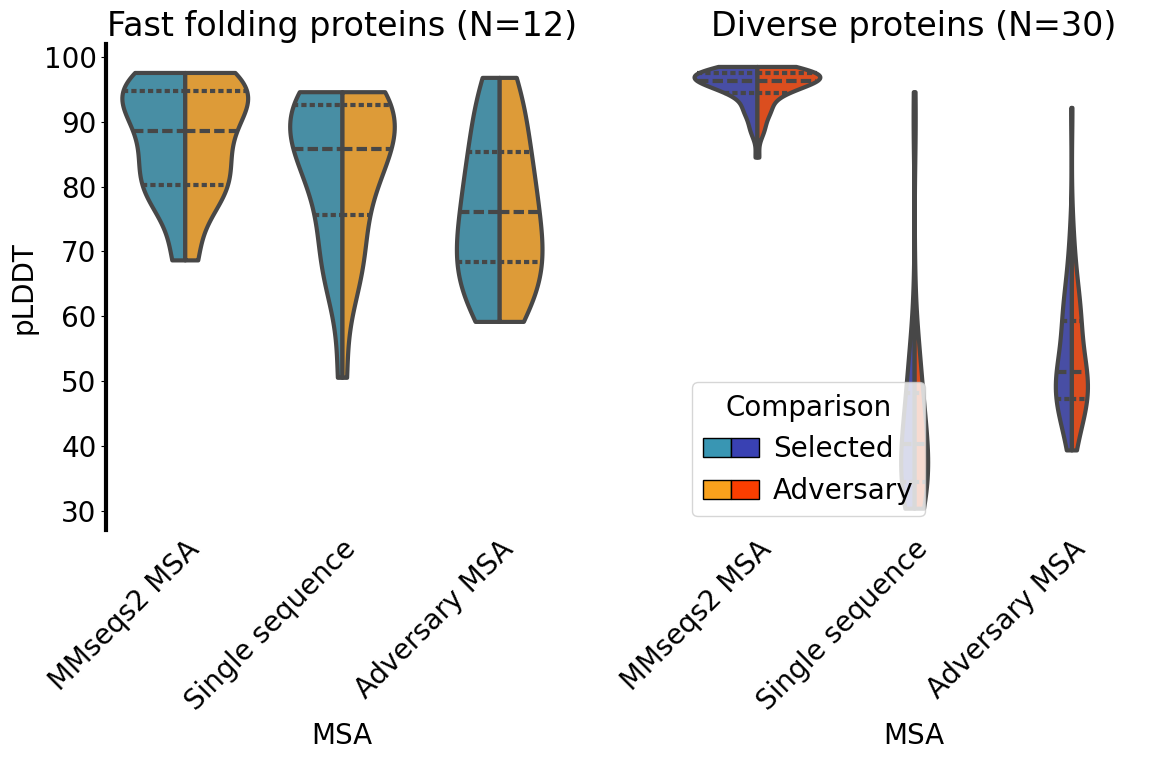

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [14]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['font.size'] = 20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax1.spines.values(), linewidth=3)
ax1.spines[["left"]].set_visible(True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax2.spines.values(), linewidth=3)
ax2.spines[["left"]].set_visible(False)
plt.tick_params(axis=u'both', which=u'both',length=0)

sns.violinplot(deshaw_df, x="MSA", y="pLDDT",hue="Comparison",inner="quart", split=True, order=["MMseqs2 MSA", "Single sequence", "Adversary MSA"], palette=["#3996B3", "#F9A11C"],ax=ax1,cut=0, linewidth=3)
ax1.get_legend().remove()
ax1.tick_params(axis=u'x', which=u'both',length=0)
ax1.set_title(f"Fast folding proteins (N={len(deshaw_examples)})")
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_title(f"Diverse proteins (N={len(other_examples)})")
sns.violinplot(other_df, x="MSA", y="pLDDT",hue="Comparison",inner="quart", split=True, order=["MMseqs2 MSA", "Single sequence", "Adversary MSA"], palette=["#3941B3", "#FA3E00"],ax=ax2,cut=0, linewidth=3)
light_blue = Patch(facecolor="#3996B3", edgecolor='black')
light_orange = Patch(facecolor="#F9A11C", edgecolor='black')
dark_blue = Patch(facecolor="#3941B3", edgecolor='black')
dark_orange = Patch(facecolor="#FA3E00", edgecolor='black')
plt.gca().legend(handles=[light_blue, light_orange, dark_blue, dark_orange],
          labels=['', '',  'Selected', 'Adversary'],
          ncol=2,  columnspacing=-0.5, handletextpad=0.5, handlelength=1.0,title="Comparison")
plt.tight_layout()
plt.savefig("visualisations/other_examples_plddt.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/other_examples_plddt.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.gcf()

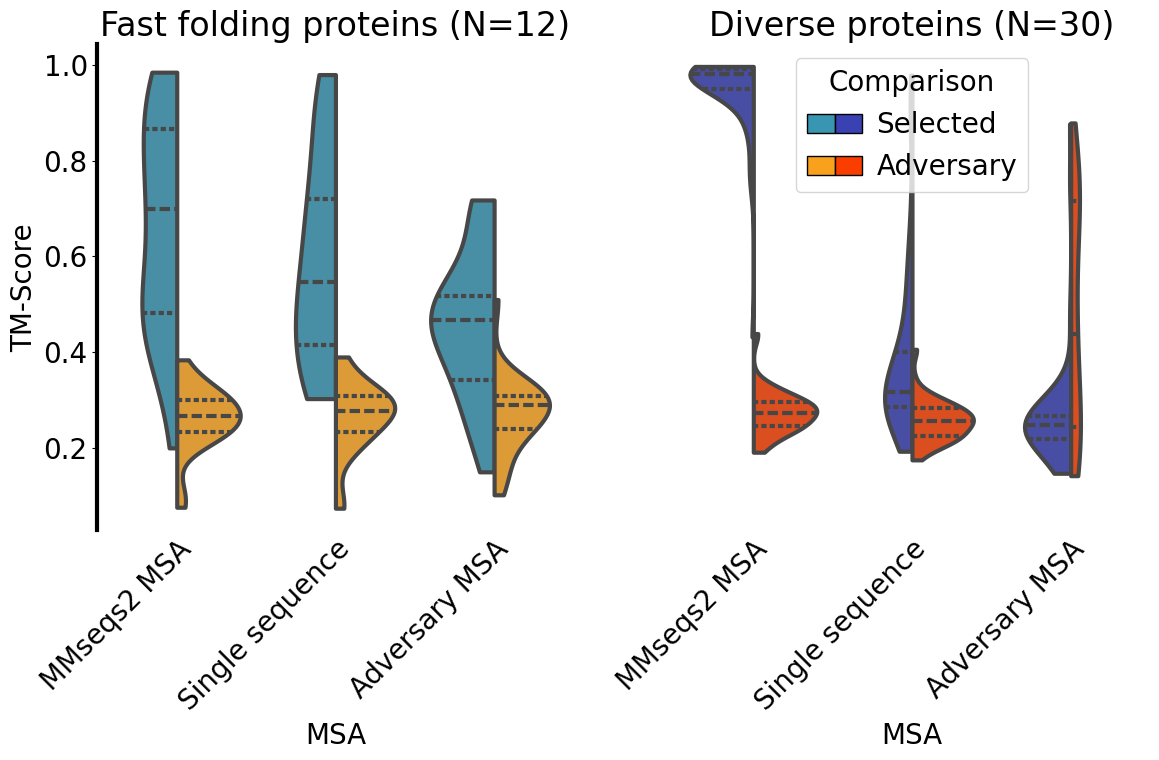

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [15]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['font.size'] = 20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax1.spines.values(), linewidth=3)
ax1.spines[["left"]].set_visible(True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax2.spines.values(), linewidth=3)
ax2.spines[["left"]].set_visible(False)
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.violinplot(deshaw_df, x="MSA", y="TM-Score",hue="Comparison",inner="quart", split=True, order=["MMseqs2 MSA", "Single sequence", "Adversary MSA"], palette=["#3996B3", "#F9A11C"],ax=ax1,cut=0,linewidth=3)
ax1.get_legend().remove()
ax1.tick_params(axis=u'x', which=u'both',length=0)
ax1.set_title(f"Fast folding proteins (N={len(deshaw_examples)})")
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_title(f"Diverse proteins (N={len(other_examples)})")
sns.violinplot(other_df, x="MSA", y="TM-Score",hue="Comparison",inner="quart", split=True, order=["MMseqs2 MSA", "Single sequence", "Adversary MSA"], palette=["#3941B3", "#FA3E00"],ax=ax2, cut=0, linewidth=3)
light_blue = Patch(facecolor="#3996B3", edgecolor='black')
light_orange = Patch(facecolor="#F9A11C", edgecolor='black')
dark_blue = Patch(facecolor="#3941B3", edgecolor='black')
dark_orange = Patch(facecolor="#FA3E00", edgecolor='black')
plt.gca().legend(handles=[light_blue, light_orange, dark_blue, dark_orange],
          labels=['', '',  'Selected', 'Adversary'],
          ncol=2,  columnspacing=-0.5, handletextpad=0.5, handlelength=1.0,title="Comparison")
plt.tight_layout()
plt.savefig("visualisations/other_examples_tm.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/other_examples_tm.pdf", format="pdf", dpi=600, transparent=True)

plt.show()
plt.gcf()

In [16]:
deshaw_examples = single_proteins_df[single_proteins_df.dataset=="DEShaw_examples"]
sec_strucs = []
for _, row in deshaw_examples.iterrows():
    first = row["first"]
    second = row["second"]
    combined_name = first+second
    _, _, _, _, _, sec_struc_start, _, _, _, _, _, _, _ = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{first}_sec_struc.json")
    sec_strucs.append({"Struc":first, "Structure":"Selected", "Dataset": row["dataset"], "Secondary structure (%)":100-sec_struc_start*100})
    _, _, _, _, _, sec_struc_adversary, _, _, _, _, _, _, _ = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{second}_sec_struc.json")
    sec_strucs.append({"Struc":second, "Structure":"Adversary", "Dataset": row["dataset"], "Secondary structure (%)":100-sec_struc_adversary*100})
    _, _, _, _, _, sec_struc_pred, _, _, _, _, _, _, _ = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{first}_main_{second}_protmpnnbest_sec_struc.json")
    sec_strucs.append({"Struc":combined_name, "Structure":"Prediction", "Dataset": row["dataset"], "Secondary structure (%)":100-sec_struc_pred*100})
deshaw_sec_strucs = pd.DataFrame(sec_strucs)

other = single_proteins_df[single_proteins_df.dataset!="DEShaw_examples"]
sec_strucs = []
for _, row in other_examples.iterrows():
    first = row["first"]
    second = row["second"]
    combined_name = first+second
    _, _, _, _, _, sec_struc_start, _, _, _, _, _, _, _ = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{first}_sec_struc.json")
    sec_strucs.append({"Struc":first, "Structure":"Selected", "Dataset": row["dataset"], "Secondary structure (%)":100-sec_struc_start*100})
    _, _, _, _, _, sec_struc_adversary, _, _, _, _, _, _, _ = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{second}_sec_struc.json")
    sec_strucs.append({"Struc":second, "Structure":"Adversary", "Dataset": row["dataset"], "Secondary structure (%)":100-sec_struc_adversary*100})
    _, _, _, _, _, sec_struc_pred, _, _, _, _, _, _, _ = open_secstruc(anchor_path/row["dataset"]/combined_name/f"{first}_main_{second}_protmpnnbest_sec_struc.json")
    sec_strucs.append({"Struc":combined_name, "Structure":"Prediction", "Dataset": row["dataset"], "Secondary structure (%)":100-sec_struc_pred*100})
other_sec_strucs = pd.DataFrame(sec_strucs)

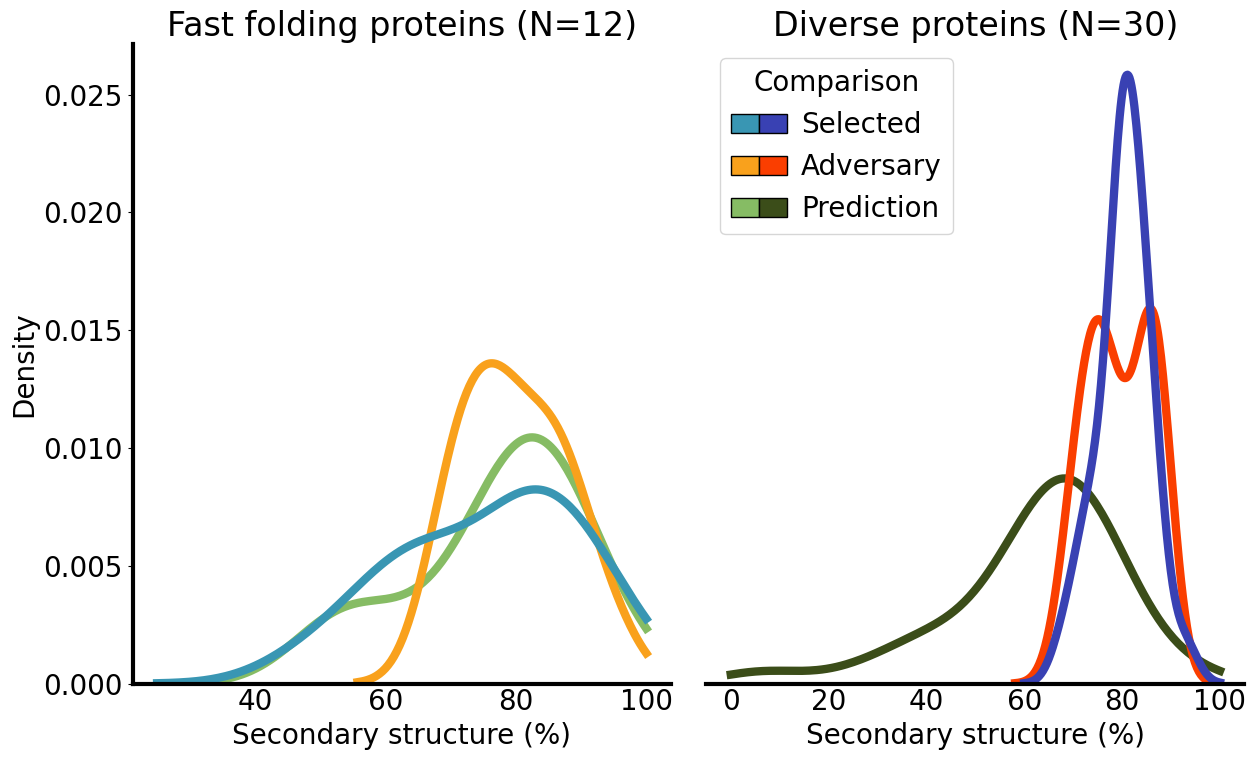

<Figure size 1300x800 with 0 Axes>

<Figure size 1300x800 with 0 Axes>

In [17]:
plt.rcParams["figure.figsize"] = (13,8)
plt.rcParams['font.size'] = 20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
#plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax1.spines.values(), linewidth=3)
ax1.spines[["left", "bottom"]].set_visible(True)
#plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax2.spines.values(), linewidth=3)
ax2.spines[["bottom"]].set_visible(True)
ax2.spines[["left"]].set_visible(False)
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.kdeplot(deshaw_sec_strucs, x="Secondary structure (%)", hue="Structure",hue_order=["Selected", "Adversary", "Prediction"], palette=["#3996B3", "#F9A11C","#86BC64"],clip=(0, 100), ax=ax1, legend=False, linewidth=6)
ax1.set_ylabel("Density")
ax1.tick_params(axis=u'x', which=u'both',length=0)
ax1.set_title(f"Fast folding proteins (N={len(deshaw_examples)})")
#ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_title(f"Diverse proteins (N={len(other_examples)})")
sns.kdeplot(other_sec_strucs, x="Secondary structure (%)", hue="Structure",hue_order=["Selected", "Adversary", "Prediction"], palette=["#3941B3", "#FA3E00", "#3B4D19"], clip=(0, 100), ax=ax2, linewidth=6)
light_blue = Patch(facecolor="#3996B3", edgecolor='black')
light_orange = Patch(facecolor="#F9A11C", edgecolor='black')
light_green = Patch(facecolor="#86BC64", edgecolor='black')
dark_blue = Patch(facecolor="#3941B3", edgecolor='black')
dark_orange = Patch(facecolor="#FA3E00", edgecolor='black')
dark_green = Patch(facecolor="#3B4D19", edgecolor='black')

plt.gca().legend(handles=[light_blue, light_orange, light_green, dark_blue, dark_orange, dark_green],
          labels=['', '', '', 'Selected', 'Adversary', 'Prediction'],
          ncol=2,  columnspacing=-0.5, handletextpad=0.5, handlelength=1.0,title="Comparison")
plt.tight_layout()
plt.savefig("visualisations/other_examples_sec_struc.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/other_examples_sec_struc.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.gcf()

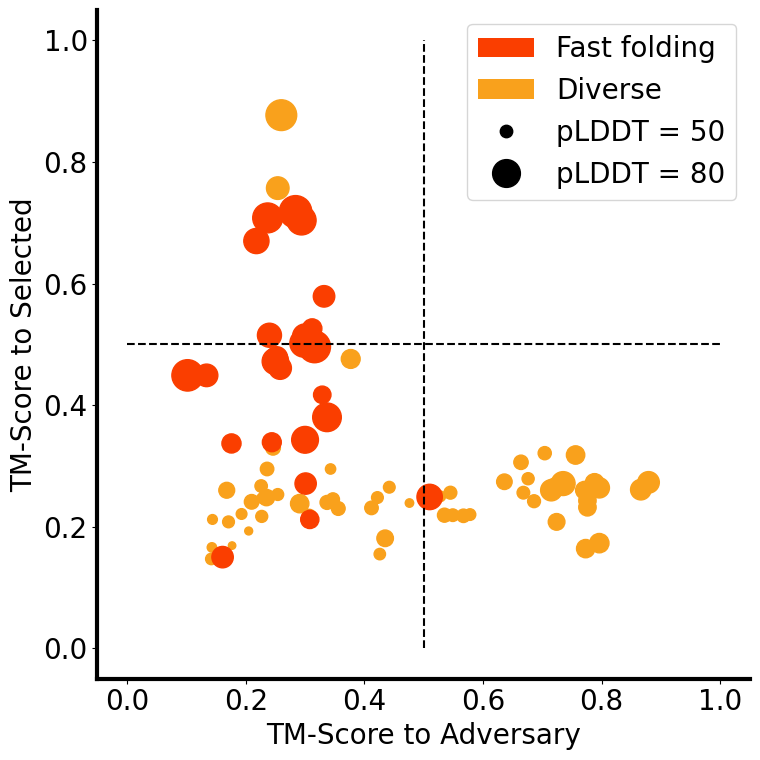

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [18]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = 20
plt.setp(plt.gca().spines.values(), linewidth=3)
combined_df = pd.concat([other_df, deshaw_df])
plt.gca().spines[["left", "bottom"]].set_visible(True)
plot = plt.scatter(other_df[(other_df.MSA=="Adversary MSA") & (other_df.Comparison=="Adversary")]["TM-Score"],other_df[(other_df.MSA=="Adversary MSA") & (other_df.Comparison=="Selected")]["TM-Score"], s=(other_df[(other_df.MSA=="Adversary MSA") & (other_df.Comparison=="Selected")]["pLDDT"]-30)**1.5, label="Diverse",c="#F9A11C" )
plt.scatter(deshaw_df[(deshaw_df.MSA=="Adversary MSA") & (deshaw_df.Comparison=="Adversary")]["TM-Score"],deshaw_df[(deshaw_df.MSA=="Adversary MSA") & (deshaw_df.Comparison=="Selected")]["TM-Score"], s=(deshaw_df[(deshaw_df.MSA=="Adversary MSA") & (deshaw_df.Comparison=="Selected")]["pLDDT"]-30)**1.5,label="Fast-folding", c="#FA3E00" )
plt.legend()
plt.plot([0.5,0.5],[0,1],linestyle="--",c="black" )
plt.plot([0,1],[0.5,0.5],linestyle="--",c="black" )
plt.xlabel("TM-Score to Adversary")
plt.ylabel("TM-Score to Selected")
line_artists, labels = plot.legend_elements("sizes", num=6)
[line_artist.set_label(f"pLDDT = {int(round(int(label[len("$\\mathdefault{"):-len("}$")])**(2/3)+30, -1))}") for (line_artist,label) in zip(line_artists, labels)] 
handles = [mpatches.Patch(facecolor="#FA3E00", label="Fast folding"), mpatches.Patch(facecolor="#F9A11C", label="Diverse"), ]+[line_artists[0],line_artists[4]]# Line2D([], [], color="white", marker='o', linestyle='none', markersize=plot.legend_elements(prop="sizes", num=3 ), markerfacecolor="black", label="pLDDT=40"), Line2D([], [], color="white", marker='o', linestyle='none',  markersize=(80-30)**1.5, markerfacecolor="black", label="pLDDT=80")]
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig("visualisations/single_proteins_scatter.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/single_proteins_scatter.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.gcf()

In [19]:
deshaw_df[(deshaw_df.MSA=="MMseqs2 MSA") & (deshaw_df.Comparison=="Selected") & (deshaw_df["TM-Score"]<0.6)]

,ids,struc,adversary,MSA,TM-Score,pLDDT,Comparison,gap_selected_tot,Relative gap selected,gap_adversary_tot,Relative gap adversary,Relative helix selected,Relative sheet selected,E_selected_relative,G_selected_relative,I_selected_relative,T_selected_relative,S_selected_relative,Relative helix adversary,Relative sheet adversary,E_adversary_relative,G_adversary_relative,I_adversary_relative,T_adversary_relative,S_adversary_relative,Contact_order_adversary_absolute,Relative contact order adversary,Contact_order_selected_absolute,Relative contact order selected
6,1mhxA1iojA,1iojA,1mhxA,MMseqs2 MSA,0.453,78.483860,Selected,7,0.122807,4,0.070175,0.508772,0.0,0.000000,0.0,0.0,0.105263,0.263158,0.245614,0.000000,0.491228,0.00000,0.000000,0.140351,0.052632,8.923669,0.156556,2.871014,0.050369
30,1viiA1k81A,1k81A,1viiA,MMseqs2 MSA,0.490,79.122778,Selected,8,0.222222,7,0.194444,0.000000,0.0,0.527778,0.0,0.0,0.138889,0.111111,0.527778,0.000000,0.000000,0.00000,0.000000,0.166667,0.111111,4.677314,0.129925,4.762280,0.132286
48,5awlA2nouA,5awlA,2nouA,MMseqs2 MSA,0.446,92.701000,Selected,5,0.500000,3,0.300000,0.000000,0.2,0.000000,0.0,0.0,0.300000,0.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.200000,0.000000,2.157341,0.215734,3.843470,0.384347
54,5awlA2nouA,2nouA,5awlA,MMseqs2 MSA,0.358,69.218000,Selected,3,0.300000,5,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.200000,0.000000,0.000000,0.200000,0.000000,0.00000,0.000000,0.300000,0.000000,3.843470,0.384347,2.157341,0.215734
60,2jofA7aldA,2jofA,7aldA,MMseqs2 MSA,0.494,95.000000,Selected,7,0.350000,6,0.300000,0.400000,0.0,0.000000,0.2,0.0,0.050000,0.000000,0.000000,0.000000,0.600000,0.00000,0.000000,0.000000,0.100000,4.786079,0.239304,4.232379,0.211619
66,2jofA7aldA,7aldA,2jofA,MMseqs2 MSA,0.408,92.360000,Selected,6,0.300000,7,0.350000,0.000000,0.0,0.600000,0.0,0.0,0.000000,0.100000,0.400000,0.000000,0.000000,0.20000,0.000000,0.050000,0.000000,4.232379,0.211619,4.786079,0.239304
72,1fmeA7mmyA,1fmeA,7mmyA,MMseqs2 MSA,0.481,84.722143,Selected,11,0.392857,7,0.250000,0.357143,0.0,0.142857,0.0,0.0,0.000000,0.107143,0.000000,0.000000,0.500000,0.00000,0.000000,0.250000,0.000000,5.180679,0.185024,4.286544,0.153091
78,1fmeA7mmyA,7mmyA,1fmeA,MMseqs2 MSA,0.200,68.684643,Selected,7,0.250000,11,0.392857,0.000000,0.0,0.500000,0.0,0.0,0.250000,0.000000,0.357143,0.000000,0.142857,0.00000,0.000000,0.000000,0.107143,4.286544,0.153091,5.180679,0.185024
90,2hbaA1fjkA,1fjkA,2hbaA,MMseqs2 MSA,0.481,78.184231,Selected,3,0.057692,9,0.173077,0.807692,0.0,0.000000,0.0,0.0,0.038462,0.096154,0.269231,0.038462,0.192308,0.00000,0.096154,0.173077,0.057692,7.003390,0.134681,2.365649,0.045493
102,2wxcA2b9kA,2b9kA,2wxcA,MMseqs2 MSA,0.515,94.175957,Selected,11,0.234043,14,0.297872,0.000000,0.0,0.574468,0.0,0.0,0.170213,0.021277,0.425532,0.000000,0.000000,0.06383,0.000000,0.063830,0.148936,5.923501,0.126032,11.818716,0.251462
